In [1]:
import numpy as np
import matplotlib.pyplot as plt

Idea behind the data model:
    y = A* x : spatial domain -> time domain
    b = Phi* y : time domain -> frequency domain
      = Phi* A* x : spatial doman -> time domain -> frequency domain
    
OMP:
    x_hat = (Phi* A)^H*b
          = A^H* Phi^H* b : frequency domain -> time domain -> spatial fomain
          = A^H* y_hat : time domain -> spatial domain 

In [2]:
def zero_array(size):
    return (0+ 0j)*np.ones(size)

def flatten_npmat(vec_like):
    vec = vec_like.flatten()
    vec = np.array(vec.T)
    return np.reshape(vec, vec.shape[0])

def dot_product_vec(A, x):
    y = np.dot(A, x)
    return flatten_npmat(y)

def Hermitian(arr):
    return np.conj(arr).T

In [3]:
#### Parameter
# Specimen
N = 220 # Dimension in the depth (z axis)
# Pulse
fS = 100 #Hz
dt = 1/fS
B = 100 #Hz**2
fC = 10 #Hz
t = dt*np.arange(0, N)

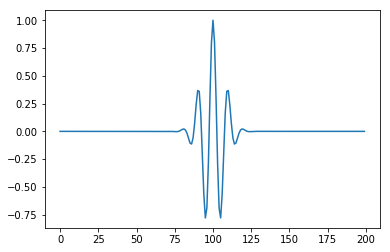

In [4]:
t_pulse = np.arange(-1, 1, dt) # pulse from -2pi to 2pi
L = len(t_pulse) # Pulse length
p_t = np.exp(-(t_pulse**2)*B)* np.cos(2*np.pi*fC*t_pulse) 
plt.plot(p_t)

In [5]:
# Measurement matrix
def calculate_Ht(vec):
    h = np.convolve(p_t, vec) # size = N + L
    h = h[int(L/2):-int(L/2)+1] # size = N
    return h
    
H_t = np.apply_along_axis(calculate_Ht, 0, (1 + 0j)*np.identity(N)) # time domain

In [6]:
# FFT of H_t
def calculate_Hf(vec):
    h_f = np.fft.fft(vec, 2*fS) # from -2pi to 2pi
    return h_f[:fS]

H_f = np.apply_along_axis(calculate_Hf, 0, H_t) # frequency domain

/Users/sayakokodera/miniconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


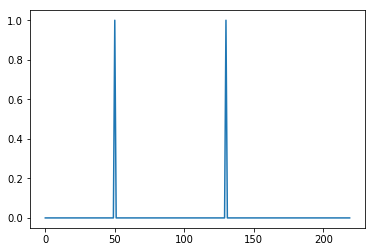

In [7]:
# Sparse vector
peak_idx = np.array([50, 130]) # position of the peaks 
K = len(peak_idx) # l0 norm of a
a = zero_array(N) # our sparse vector to recover
a[peak_idx] = 1 + 0j
plt.plot(a)

/Users/sayakokodera/miniconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


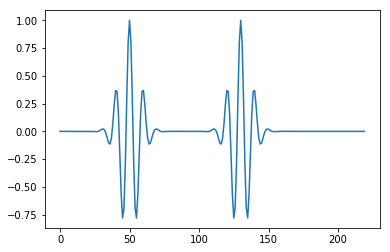

In [8]:
# Measurement data
s_t = dot_product_vec(H_t, a)
plt.plot(s_t)

In [17]:
# Measurement kernel Phi
def calculate_DFT_coefficients(f):
    return np.exp(-1j*2*np.pi*f*t)
    #return np.exp(-1j*2*np.pi*f*dt*np.arange(0, fS))

def normalize_column_vector(vec):
    # Normalize the vector, s.t. norm(PhiH[:, col]) == 1
    norm = np.linalg.norm(vec)
    return vec/norm

mu, sigma = fC/fS, 0.3
np.random.seed(0)
f_normalized = np.random.normal(mu, sigma, size = K)
print(f_normalized)

Phi = np.apply_along_axis(calculate_DFT_coefficients, 0, f_normalized[np.newaxis, :])
#PhiH = np.matrix(np.dot(Phi.T, H_f))
#PhiH = np.matrix(np.dot(Phi.T, H_t))
PhiH = np.dot(Hermitian(Phi), H_t)
PhiH = np.apply_along_axis(normalize_column_vector, 0, PhiH) # normalized to norm(PhiH) == 1
print(Phi.shape)
print(PhiH.shape)

[0.6292157  0.22004716]
(220, 2)
(2, 220)


[0.01658287+0.00733671j 0.28237741+0.83402191j]


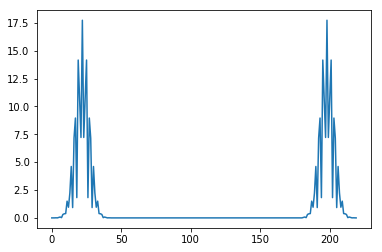

In [18]:
# Compressed measuement data
b = dot_product_vec(PhiH, a)
print(b)

S_f = np.fft.fft(s_t)
plt.plot(np.abs(S_f))

3.4219371797089426e-16


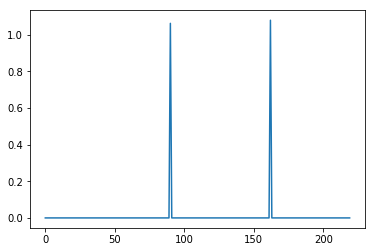

In [22]:
# OMP
r = np.copy(b)
error = np.linalg.norm(r)
S = []
x_hat = zero_array(N)
target = 10**-3

while error > target:
    S.append(np.argmax(dot_product_vec(Hermitian(PhiH), r)))
    PhiH_S = PhiH[:, S] # size = K x idx
    x_S = dot_product_vec(np.linalg.pinv(PhiH_S), b)
    r = b - dot_product_vec(PhiH_S, x_S)
    x_hat[S] = x_S 
    error = np.linalg.norm(r)
plt.plot(np.abs(x_hat))
print(error)

In [23]:
S

[90, 162]

In [13]:
x_S

array([0.11581353+0.00660475j, 0.07863084+0.00362389j])